#### Objective:
This script implements a **matrix factorization approach** using **stochastic gradient descent (SGD)** to recommend movies based on user-item interaction data. The user-item matrix is decomposed into latent factors, with bias terms for users and items, to predict missing ratings.

#### Mathematical Formulation:

1. **User-Item Matrix**:
   Construct the user-item matrix $R \in \mathbb{R}^{m \times n}$, where:
   - $m$: Number of users,
   - $n$: Number of items,
   - $R_{ui}$: Rating given by user $u$ to item $i$ (or $0$ if not rated).

2. **Latent Factor Decomposition**:
   Decompose $R$ into:
   $R_{ui} \approx \hat{R}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i^\top$.
   Where:
   - $\mu$: Global mean rating,
   - $b_u$: Bias for user $u$,
   - $b_i$: Bias for item $i$,
   - $P_u$: Latent factors for user $u$,
   - $Q_i$: Latent factors for item $i$,
   - $k$: Number of latent dimensions (hyperparameter).

3. **Optimization**:
   Minimize the loss function:
   $\mathcal{L} = \sum_{(u, i) \in \mathcal{K}} \left( R_{ui} - \hat{R}_{ui} \right)^2 + \lambda \left( \|P\|_F^2 + \|Q\|_F^2 + \|b_u\|_2^2 + \|b_i\|_2^2 \right)$.
   Where:
   - $\mathcal{K}$: Set of observed ratings,
   - $\lambda$: Regularization parameter,
   - $\| \cdot \|_F$: Frobenius norm for latent factors,
   - $\| \cdot \|_2$: L2 norm for biases.

4. **Stochastic Gradient Descent**:
   Update parameters iteratively for each observed rating $(u, i)$:
   - Biases:
     $b_u \gets b_u + \gamma \left( e_{ui} - \lambda b_u \right), \quad b_i \gets b_i + \gamma \left( e_{ui} - \lambda b_i \right)$,
   - Latent Factors:
     $P_u \gets P_u + \gamma \left( e_{ui} Q_i - \lambda P_u \right), \quad Q_i \gets Q_i + \gamma \left( e_{ui} P_u - \lambda Q_i \right)$.
   Where:
   - $e_{ui} = R_{ui} - \hat{R}_{ui}$,
   - $\gamma$: Learning rate.

5. **Predicted Ratings**:
   After training, predict ratings as:
   $\hat{R}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i^\top$.

6. **Recommendations**:
   For the target user $u$:
   - Predict ratings for all items: $\hat{R}_{u, :}$,
   - Exclude items already rated by $u$,
   - Rank remaining items by predicted score and return the top $N$ recommendations.

#### Hyperparameters:
- `latent_factors (k)`: Number of latent dimensions.
- `learning_rate (\gamma)`: Step size for gradient updates.
- `regularization (\lambda)`: Penalization for large latent factor values.
- `max_iterations`: Number of optimization steps.
- `target_user_id`: User ID for recommendations.
- `top_n_recommendations`: Number of recommendations to display.



Base Data Tables:
Movies Table: 9742 rows, 3 columns
Ratings Table: 100836 rows, 4 columns

Movies Table (Sample):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Table (Sample):
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Step 1: Creating User-Item Matrix..

/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_18401/3489007029.py:101: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


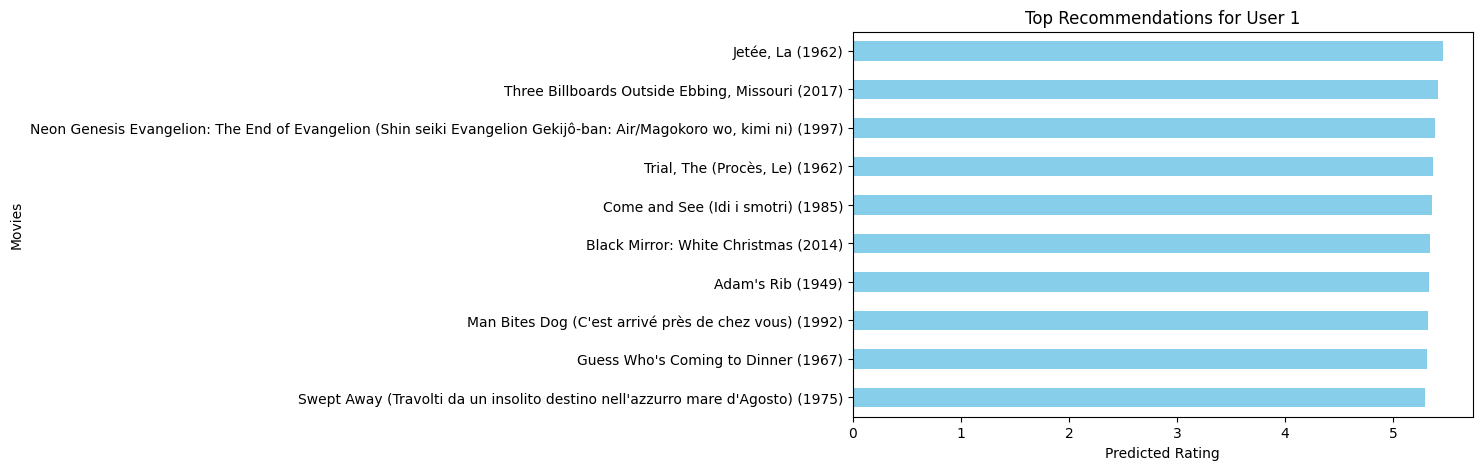

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hyperparameters and Variables
path = 'data/ml-latest-small/'  # Path to dataset
movies_path = path + "movies.csv"
ratings_path = path + "ratings.csv"
latent_factors = 10  # Number of latent factors (k)
learning_rate = 0.01  # Learning rate for SGD
regularization = 0.1  # Regularization parameter (lambda)
max_iterations = 50  # Number of iterations for SGD
target_user_id = 1  # ID of the target user for recommendations

# Load datasets
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Describe base data tables
print("\nBase Data Tables:")
print(f"Movies Table: {movies.shape[0]} rows, {movies.shape[1]} columns")
print(f"Ratings Table: {ratings.shape[0]} rows, {ratings.shape[1]} columns")

# Display sample data
print("\nMovies Table (Sample):")
print(movies.head(5))
print("\nRatings Table (Sample):")
print(ratings.head(5))

# Step 1: Create User-Item Matrix
print("\nStep 1: Creating User-Item Matrix...")
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating").fillna(0)
print("User-Item Matrix (First 5 Users, First 5 Movies):")
print(user_item_matrix.iloc[:5, :5])

# Step 2: Initialize Parameters
print("\nStep 2: Initializing Parameters...")
num_users, num_items = user_item_matrix.shape
P = np.random.normal(scale=1./latent_factors, size=(num_users, latent_factors))  # User latent factors
Q = np.random.normal(scale=1./latent_factors, size=(num_items, latent_factors))  # Item latent factors
b_u = np.zeros(num_users)  # User biases
b_i = np.zeros(num_items)  # Item biases
global_mean = user_item_matrix.values[user_item_matrix.values > 0].mean()  # Global mean rating

print(f"Number of Users: {num_users}, Number of Items: {num_items}")
print(f"Global Mean Rating: {global_mean:.2f}")

# Step 3: Train Matrix Factorization Model
print("\nStep 3: Training Matrix Factorization Model...")
for iteration in range(max_iterations):
    for user in range(num_users):
        for item in range(num_items):
            rating = user_item_matrix.values[user, item]
            if rating > 0:  # Only consider observed ratings
                # Compute prediction and error
                prediction = global_mean + b_u[user] + b_i[item] + np.dot(P[user, :], Q[item, :])
                error = rating - prediction

                # Update biases
                b_u[user] += learning_rate * (error - regularization * b_u[user])
                b_i[item] += learning_rate * (error - regularization * b_i[item])

                # Update latent factors
                P[user, :] += learning_rate * (error * Q[item, :] - regularization * P[user, :])
                Q[item, :] += learning_rate * (error * P[user, :] - regularization * Q[item, :])

    # Compute training loss
    loss = 0
    for user in range(num_users):
        for item in range(num_items):
            rating = user_item_matrix.values[user, item]
            if rating > 0:
                prediction = global_mean + b_u[user] + b_i[item] + np.dot(P[user, :], Q[item, :])
                loss += (rating - prediction) ** 2
    loss += regularization * (np.sum(b_u ** 2) + np.sum(b_i ** 2) + np.sum(P ** 2) + np.sum(Q ** 2))
    print(f"Iteration {iteration + 1}/{max_iterations}, Loss: {loss:.2f}")

# Step 4: Generate Recommendations
print("\nStep 4: Generating Recommendations...")
user_index = target_user_id - 1  # Adjust for zero indexing
predictions = global_mean + b_u[user_index] + b_i + np.dot(P[user_index, :], Q.T)
rated_items = user_item_matrix.columns[user_item_matrix.values[user_index, :] > 0]
unrated_items = [item for item in user_item_matrix.columns if item not in rated_items]
recommendations = pd.DataFrame({
    "movieId": unrated_items,
    "predicted_rating": predictions[np.isin(user_item_matrix.columns, unrated_items)]
}).sort_values(by="predicted_rating", ascending=False).head(10)

# Map Movie IDs to Titles
recommendations = recommendations.merge(movies, on="movieId")
print("\nTop 10 Recommendations:")
print(recommendations[["title", "predicted_rating"]])

# Optional: Visualization
plt.figure(figsize=(8, 5))
recommendations.set_index("title")["predicted_rating"].plot(kind="barh", color="skyblue")
plt.title(f"Top Recommendations for User {target_user_id}")
plt.xlabel("Predicted Rating")
plt.ylabel("Movies")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()